Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [166]:
import os
import pandas as pd
import numpy as np
import sys
import os
def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.crawler.fifa import extract_attributes


New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


In [167]:

def add_features_raw_datadf_raw(df_raw):
    df_raw = df_raw.set_index(['ID','Name','FIFA'])
    best_pos = lambda x: x.split(',')[0]

    # Apply the lambda function to add best position
    df_raw["best_position"] = df_raw['Position'].apply(best_pos)
    df_raw["best_position"].value_counts()
    encoded_pos = pd.read_csv("position_mapping.csv")
    df_raw = pd.merge(df_raw.reset_index(), encoded_pos, left_on='best_position', right_on='best_position', how='inner')
    df_raw = df_raw.set_index(['ID','Name','FIFA'])
    df_raw['Defense'] =  df_raw['Defensive awareness'].fillna(0)+df_raw['Marking'].fillna(0)
    return df_raw

### Get Data

In [168]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_prospect = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>84)
GROUP BY ID
order by potential DESC;
"""


In [169]:
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_prospect = pd.read_sql_query(sql_prospect, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_prospect = df_prospect.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_prospect.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,€0,2121.0,"RW,RF,ST,CAM",11360.0,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,€0,2223.0,"RW,CAM,LW,ST",11359.0,84.0,89.0,87.0,81.0,85.0,93.0,88.0,88.0,71.0,95.0,93.0,94.0,94.0,88.0,84.0,93.0,91.0,85.0,80.0,91.0,61.0,24.0,88.0,80.0,82.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,€105K,1911.0,"RW,LW,CAM",12092.0,69.0,73.0,66.0,71.0,66.0,85.0,84.0,56.0,67.0,83.0,81.0,78.0,83.0,79.0,67.0,74.0,63.0,77.0,71.0,74.0,53.0,32.0,74.0,75.0,67.0,NaN,34.0,32.0,5.0,9.0,6.0,15.0,7.0,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,€0,1958.0,"RW,LW,CF,RM",11226.0,74.0,76.0,64.0,80.0,67.0,84.0,68.0,64.0,68.0,86.0,87.0,86.0,83.0,78.0,76.0,72.0,67.0,74.0,56.0,74.0,54.0,42.0,80.0,82.0,75.0,35.0,32.0,29.0,11.0,12.0,6.0,8.0,8.0,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,€90K,1929.0,"RW,LW",12571.0,72.0,78.0,62.0,73.0,67.0,84.0,80.0,73.0,57.0,80.0,88.0,86.0,87.0,78.0,85.0,71.0,73.0,81.0,45.0,71.0,54.0,21.0,83.0,71.0,74.0,NaN,36.0,32.0,9.0,8.0,12.0,8.0,5.0,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0


In [170]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<83)&(df.Age<26)&(df.Potential>83)]

In [171]:

df = df[df.prime_age>df.potential_age]
df['target'] = ~(df.PrimeOverall<83)
df = df[df.potential_age<26]
df = df[df.offense>-2]
df.target.value_counts()


df_processed = df.copy()
df_processed.head()

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense,set,target
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,€0,2121.0,"RW,RF,ST,CAM",11360.0,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0,drop,True
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,€0,2223.0,"RW,CAM,LW,ST",11359.0,84.0,89.0,87.0,81.0,85.0,93.0,88.0,88.0,71.0,95.0,93.0,94.0,94.0,88.0,84.0,93.0,91.0,85.0,80.0,91.0,61.0,24.0,88.0,80.0,82.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0,drop,True
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,€0,1958.0,"RW,LW,CF,RM",11226.0,74.0,76.0,64.0,80.0,67.0,84.0,68.0,64.0,68.0,86.0,87.0,86.0,83.0,78.0,76.0,72.0,67.0,74.0,56.0,74.0,54.0,42.0,80.0,82.0,75.0,35.0,32.0,29.0,11.0,12.0,6.0,8.0,8.0,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0,drop,True
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,€90K,1929.0,"RW,LW",12571.0,72.0,78.0,62.0,73.0,67.0,84.0,80.0,73.0,57.0,80.0,88.0,86.0,87.0,78.0,85.0,71.0,73.0,81.0,45.0,71.0,54.0,21.0,83.0,71.0,74.0,NaN,36.0,32.0,9.0,8.0,12.0,8.0,5.0,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0,test,False
208790,Z. Bakkali,2014,17.0,17.0,https://cdn.sofifa.net/players/208/790/14_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,73.0,90.0,PSV,https://cdn.sofifa.net/meta/team/682/30.png,€2.1M,€30K,1734.0,"RW,LW",9423.0,64.0,64.0,27.0,62.0,69.0,86.0,74.0,67.0,52.0,78.0,87.0,83.0,87.0,66.0,92.0,69.0,68.0,57.0,30.0,72.0,36.0,25.0,65.0,67.0,56.0,25.0,25.0,25.0,10.0,5.0,15.0,11.0,15.0,NaN,NaN,90.0,20.0,74.0,RW,0,1,1.0,25.0,train,False


In [172]:
df_processed.best_position.value_counts()

best_position
CB     120
CM     119
ST     111
CAM     98
LM      55
RM      52
RW      50
LW      50
CDM     47
LB      36
RB      30
CF      21
LWB      9
RF       4
LF       2
RWB      2
Name: count, dtype: int64

In [173]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,True,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,True,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,True,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,False,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,False,train,RW


In [174]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [175]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head(100)

winger                -0.04
offense               -0.01
GKDiving              -0.01
GKPositioning         -0.00
GKHandling             0.02
GKReflexes             0.03
central                0.04
GKKicking              0.04
Defense                0.04
Agility                0.05
Marking                0.05
Balance                0.06
Acceleration           0.06
SprintSpeed            0.07
StandingTackle         0.08
SlidingTackle          0.08
Jumping                0.12
Interceptions          0.14
Defensive awareness    0.14
Finishing              0.16
Dribbling              0.17
Aggression             0.18
Strength               0.18
Crossing               0.19
Positioning            0.19
FKAccuracy             0.20
HeadingAccuracy        0.20
Penalties              0.20
Curve                  0.22
Unnamed: 0             0.22
Volleys                0.22
LongShots              0.23
Stamina                0.24
Vision                 0.24
Composure              0.25
max_potential       

In [176]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
df[df.target].describe().round(3).compare(df[~df.target].describe().round(3))



potential_age               Age           Overall          Potential  \
               self    other     self    other     self    other      self   
count       291.000  515.000  291.000  515.000  291.000  515.000   291.000   
mean         21.636   20.039   21.636   20.039   78.880   73.214    86.605   
std           2.231    2.067    2.231    2.067    4.123    4.648     1.718   
min          17.000   16.000   17.000   16.000   63.000   59.000       NaN   
25%          20.000   18.500   20.000   18.500   77.000   70.000       NaN   
50%          22.000   20.000   22.000   20.000   80.000   74.000    86.000   
75%          23.000   21.000   23.000   21.000   82.000   77.000    87.000   
max             NaN      NaN      NaN      NaN   90.000   81.000    95.000   

                 Special           Unnamed: 0            Crossing           \
         other      self     other       self      other     self    other   
count  515.000   291.000   515.000    291.000    515.000  291.000  515.000   
mean    85.839  1953.337  1818.581  11615.179  10506.173   67.024   61.773   
std      1.096   154.794   158.597   2286.029   2466.300   13.469   12.531   
min        NaN  1455.000  1341.000   5300.000   2018.000   26.000   23.000   
25%        NaN  1852.000  1700.500  10360.500   9326.000   60.500   55.000   
50%     85.000  1966.000  1828.000  11129.000  10655.000   69.000   64.000   
75%     86.000  2054.000  1933.500  12177.500  12054.500   77.000   70.000   
max     90.000  2316.000  2193.000  17381.000  17148.000   89.000   88.000   

      Finishing          HeadingAccuracy          ShortPassing           \
           self    other            self    other         self    other   
count   291.000  515.000         291.000  515.000      291.000  515.000   
mean     64.052   58.637          64.251   58.586       76.399   70.701   
std      16.796   15.555          13.313   12.885        7.064    7.735   
min      10.000   17.000          27.000   17.000       53.000   36.000   
25%      58.000   50.500          55.000   50.000       72.500   66.000   
50%      67.000   63.000          64.000   59.000       77.000   72.000   
75%      76.000   70.000          75.000   68.000       82.000   76.000   
max      92.000   87.000          92.000   86.000       93.000   88.000   

       Volleys          Dribbling             Curve          FKAccuracy  \
          self    other      self    other     self    other       self   
count  291.000  515.000   291.000  515.000  291.000  515.000    291.000   
mean    61.722   54.577    75.924   71.790   66.756   60.258     59.485   
std     16.090   14.261    11.161   11.236   14.889   13.708     16.158   
min     14.000   11.000    33.000   13.000   13.000   20.000     10.000   
25%     54.500   44.000    72.000   68.000   60.000   52.000     48.000   
50%     65.000   58.000    78.000   74.000   71.000   63.000     63.000   
75%     73.500   66.000    84.000   79.000   78.000   70.000     72.500   
max     91.000   84.000    97.000   89.000      NaN      NaN     88.000   

               LongPassing          BallControl          Acceleration  \
         other        self    other        self    other         self   
count  515.000     291.000  515.000     291.000  515.000      291.000   
mean    52.885      69.402   63.183      78.615   73.515       78.306   
std     14.630      10.955   10.814       7.471    7.101        9.305   
min     17.000      33.000   31.000      45.000   40.000       48.000   
25%     42.000      64.000   56.000      75.000   70.000       72.000   
50%     54.000      71.000   65.000      80.000   75.000       79.000   
75%     64.500      78.000   72.000      83.000   78.500       85.000   
max     86.000      92.000   85.000      96.000   87.000       94.000   

               SprintSpeed           Agility          Reactions           \
         other        self    other     self    other      self    other   
count  515.000     291.000  515.000  291.000  515.000   291

###  Feature Engineering

In [177]:
PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','winger','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = [ 'Defense','winger','offense','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',  'Dribbling', 'Curve',  'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',  'Composure',  'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'StandingTackle', 'SlidingTackle']
# PLAYER_ATTRIBUTES = [ 'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance',  'Jumping', 'Stamina', 'Strength',  'Aggression', 'Positioning', 'Vision']

#### Transform Defense Attributs

#### Transform Value

In [178]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [179]:
df['target'].value_counts()

target
False    515
True     291
Name: count, dtype: int64

In [180]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [181]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [182]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

In [183]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import shap 
import shap  # For SHAP values
import pickle

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights),
    'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights),
    'Support Vector Classifier': SVC(class_weight=class_weights,probability=True,kernel='linear'),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier()
}

model_results = {}

for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }
    if False:
        try:
            # Interpret the model using SHAP values
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test_scaled_df)
            # Save SHAP values to a pickle file
            with open(f"{model_name}_shap_values.pkl", "wb") as file:
                pickle.dump(shap_values, file)
        except:
            print("Fehler bei SHAP",model_name)

# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


Logistic Regression training----->
Decision Tree Classifier training----->
Random Forest Classifier training----->
Support Vector Classifier training----->
XGBoost Classifier training----->
LightGBM Classifier training----->
[LightGBM] [Info] Number of positive: 160, number of negative: 188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 348, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459770 -> initscore=-0.161268
[LightGBM] [Info] Start training from score -0.161268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

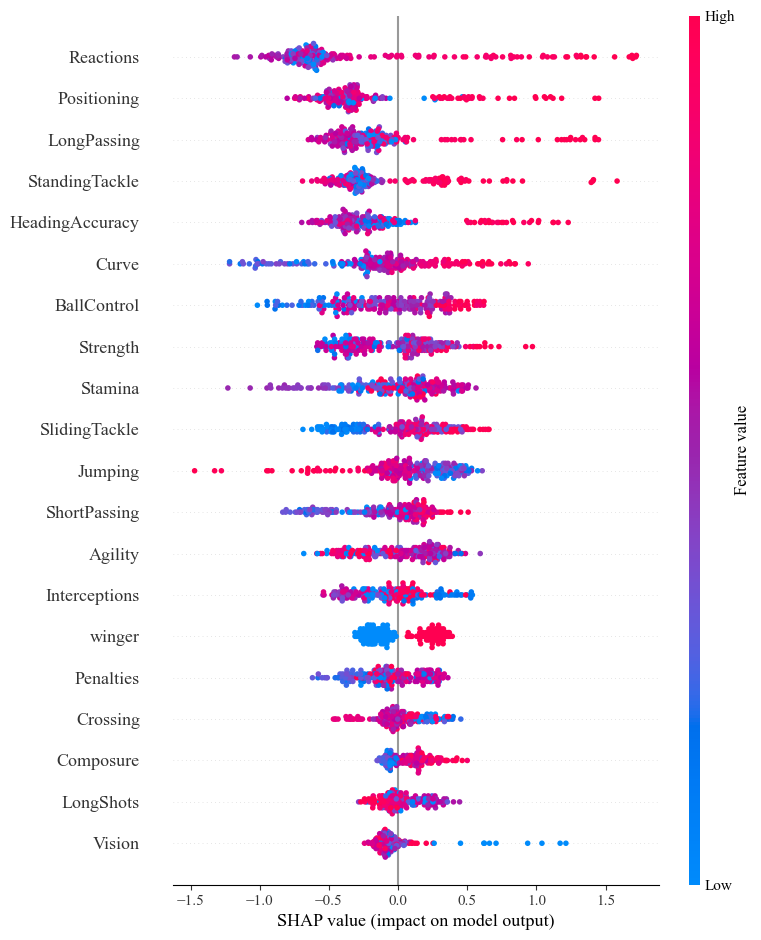

In [184]:
from src.sport_analytics.model.eval import individual_shap_valuess
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values[1], X_test_scaled_df)

In [185]:
X_test_scaled_df[~y_test].head(10)

,,,Defense,winger,offense,Crossing,Finishing,HeadingAccuracy,ShortPassing,Dribbling,Curve,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Composure,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,StandingTackle,SlidingTackle
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
243812,Rodrygo,2021,-0.985685,1.396121,1.252933,0.637094,1.078538,0.086814,-0.076545,0.875146,1.148553,-0.875063,0.532116,1.071045,0.960496,1.042354,1.686088,0.715452,1.143520,0.106003,0.450379,0.874765,-1.439428,0.535339,-0.474267,-1.427201,1.150318,0.287791,1.165849,-0.744631,-0.789924
255475,Antony,2021,-0.520776,1.396121,1.252933,0.027795,0.585654,-1.168913,-0.076545,0.875146,0.742358,-0.407000,1.054108,1.485182,1.298695,1.492626,1.536823,0.127201,1.143520,-0.081728,-0.958446,0.446610,-0.889041,0.463906,0.265845,-0.623173,0.624372,0.771612,0.445218,-0.701442,-1.264102
246045,P. De la Vega,2020,-0.858891,1.396121,1.252933,-0.048367,-0.030451,-1.168913,-1.126305,0.294575,-0.408530,-1.249514,-0.511867,0.760442,1.073229,0.952300,1.268147,-2.078741,0.586063,0.293735,1.242843,-0.516739,-0.407453,-0.393294,-1.399406,-1.382533,0.032683,-0.760490,-0.996045,-1.003762,-0.746817
247394,D. Kulusevski,2021,0.070927,1.396121,1.252933,0.789419,0.585654,-0.504116,0.710775,0.543391,0.742358,0.622739,0.793112,0.449839,0.396832,-1.028898,1.566676,1.009578,-0.528852,-0.175593,-0.958446,1.838114,0.486927,0.892506,0.327521,0.091519,0.492886,0.852249,-0.195344,0.464650,0.330859
247181,G. Plata,2021,-0.224925,1.396121,1.252933,0.332444,0.277601,-1.464378,-0.732645,0.460453,0.877756,-1.904803,0.140623,0.863976,0.847763,0.952300,1.566676,-0.019862,0.745336,0.012138,-1.486756,-0.302661,-0.201057,0.106739,-0.042535,-0.578505,0.492886,0.287791,0.044867,-0.312745,-0.531282
246420,J. Doku,2020,-0.901156,1.396121,1.252933,-0.200692,-0.461725,-1.759843,-1.388746,-0.037179,-0.340831,-2.560091,-0.642364,1.071045,1.185962,1.582680,0.969619,-3.402306,1.302794,-1.865175,1.771152,-2.978630,-2.265009,-1.107627,-0.227563,-1.561206,-0.821980,-0.921764,-0.915975,-1.090140,-1.091673
236593,C. Stengs,2020,-0.393982,1.396121,1.252933,0.408607,0.215991,-1.390512,0.185895,0.377514,0.268463,0.529127,0.793112,0.035701,-0.054099,0.411973,1.506971,0.715452,-0.210305,-0.832653,-1.398704,0.018455,-0.682646,-0.321860,-0.905999,-1.159192,0.229912,1.013523,-0.595694,-0.960574,-0.876138
235889,C. Ünder,2020,-0.224925,1.396121,1.252933,1.474880,0.647264,-0.208651,-0.207765,0.792207,1.148553,-0.126162,0.793112,0.760442,0.171367,0.772191,1.268147,-0.313988,0.904610,1.138525,-1.750910,-0.623778,-1.026638,1.321105,-2.139518,-1.069855,0.492886,0.449065,0.365148,-0.874197,-0.876138
221992,H. Lozano,2019,-0.267189,1.396121,1.252933,0.865581,0.955317,-0.060918,-0.338985,0.792207,0.539260,-0.126162,0.532116,1.692251,1.749626,1.402572,1.536823,0.568389,0.426789,0.481466,0.626482,0.553649,-0.613848,0.749639,-0.165887,-0.355164,0.755859,0.529702,0.365148,-0.787819,-0.919245


In [186]:
from sklearn.metrics import precision_score
y_score = model.predict_proba(X_test_scaled_df)[:,1]>0.1
pre = np.round(precision_score(y_pred=y_score,y_true=y_test),3)
print("Potentials:",sum(y_score),"Precision:",pre,"------> Correct Potentials",pre*sum(y_score))
X_test[y_score]
shap_values = explainer.shap_values(X_test_scaled_df)
shaps = individual_shap_valuess(values = shap_values[1], attributes = PLAYER_ATTRIBUTES,player_index = X_test_scaled_df.index)

Potentials: 112 Precision: 0.286 ------> Correct Potentials 32.032


In [187]:
%load_ext autoreload
%autoreload 2
from src.sport_analytics.model.eval import plot_feature_importance
if False:
    # Example usage:
    my_model = model_results['LightGBM Classifier']['Model']
    features = plot_feature_importance(my_model, 'LightGBM Classifier')

    my_model = model_results['Random Forest Classifier']['Model']
    features = plot_feature_importance(my_model, 'Random Forest Classifier')
    


    my_model = model_results['XGBoost Classifier']['Model']
    features = plot_feature_importance(my_model, 'XGBoost Classifier')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### evaluate test data

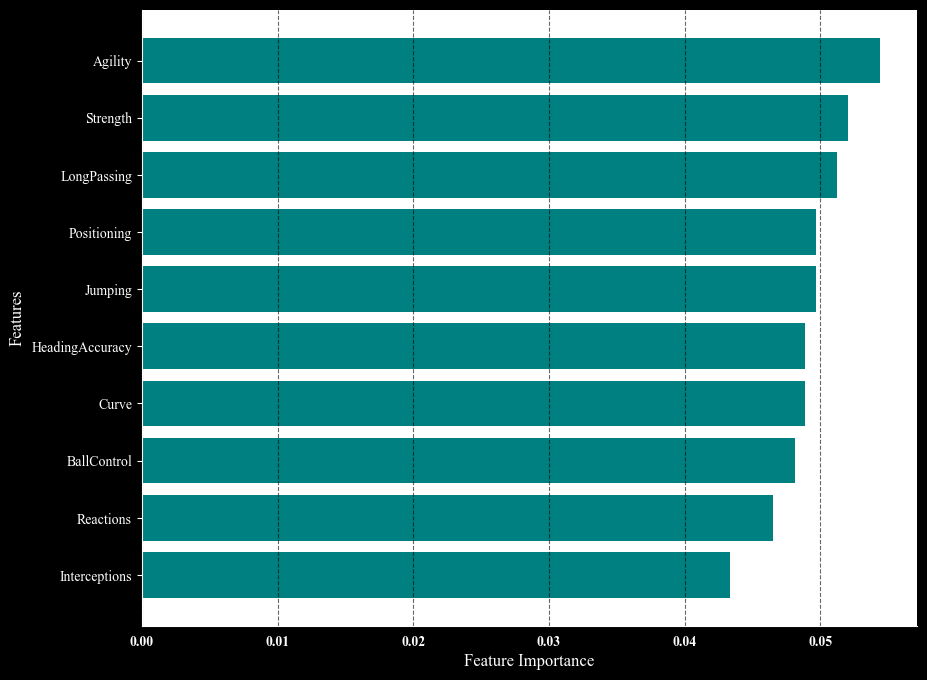

['Agility',
 'Strength',
 'LongPassing',
 'Positioning',
 'Jumping',
 'HeadingAccuracy',
 'Curve',
 'BallControl',
 'Reactions',
 'Interceptions']

In [188]:
my_model = model_results['LightGBM Classifier']['Model']
features = plot_feature_importance(my_model, '')
features

In [189]:
import pickle

try:
    # Interpret the model using SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    # Save SHAP values to a pickle file
    with open(f"{model_name}_shap_values.pkl", "wb") as file:
        pickle.dump(shap_values, file)
except:
    print("Fehler bei SHAP",model_name)

### predict potentials

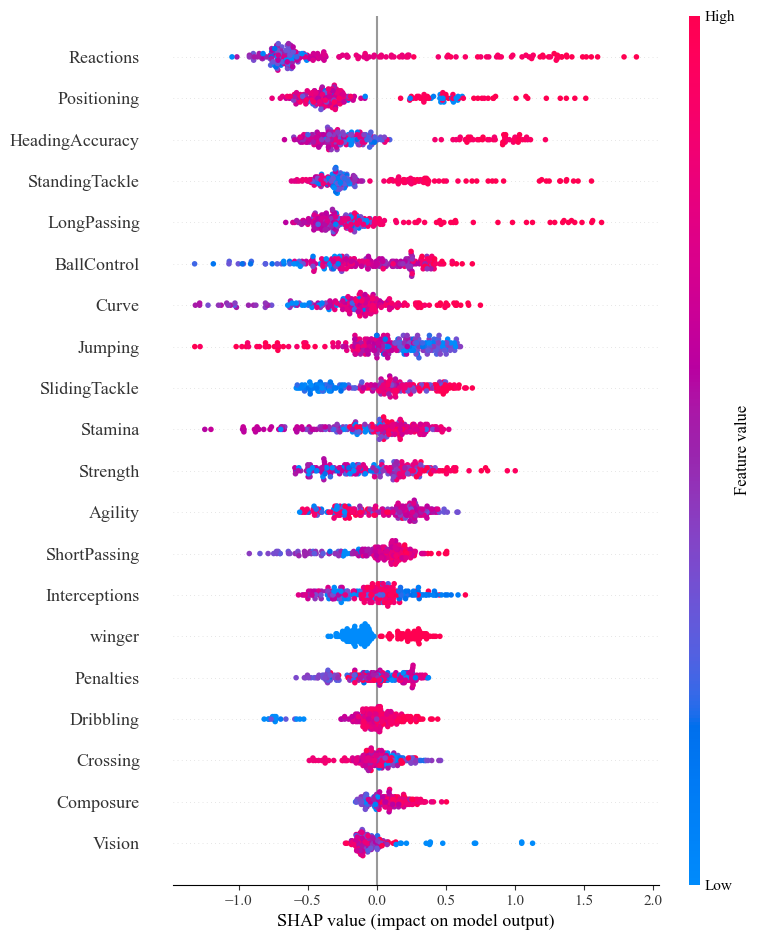

In [190]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(df_potentials_scaled_df)
shap.summary_plot(shap_values[1], df_potentials_scaled_df)

In [191]:

from src.sport_analytics.model.eval import individual_shap_valuess

shaps = individual_shap_valuess(values = shap_values[1], attributes = PLAYER_ATTRIBUTES,player_index = df_potentials_scaled_df.index)



In [192]:
prospects = pd.DataFrame(my_model.predict_proba(df_potentials_scaled_df)[:,1],columns=["prediction"],index=df_potentials.index)
joined_df = shaps.join(prospects)

pred 0.9965993964709002
[(232411, 'C. Nkunku', 2022)]


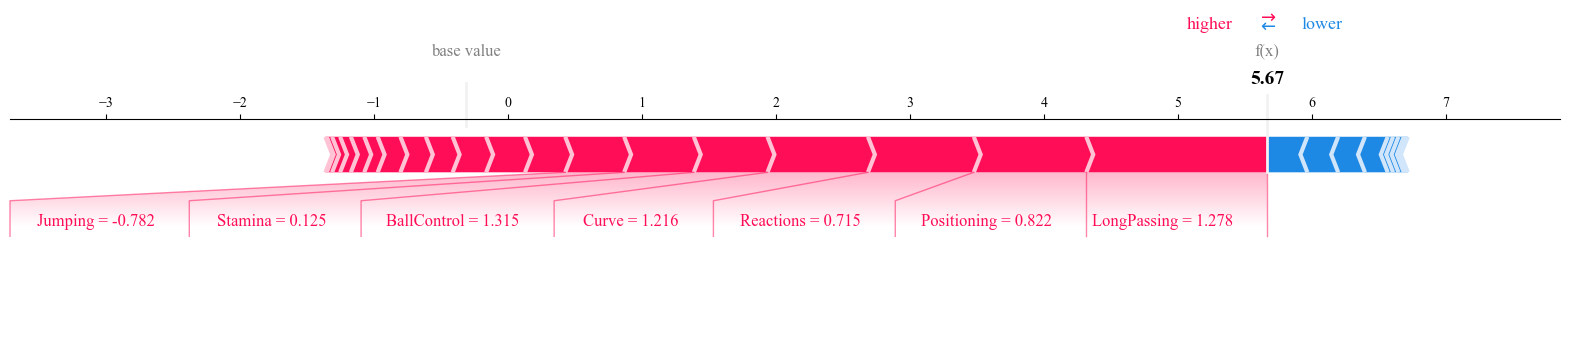

Defense            69.0
winger                0
offense             0.0
Crossing           81.0
Finishing          74.0
HeadingAccuracy    59.0
ShortPassing       83.0
Dribbling          86.0
Curve              81.0
LongPassing        80.0
BallControl        86.0
Acceleration       81.0
SprintSpeed        78.0
Agility            85.0
Composure          79.0
Reactions          78.0
Balance            83.0
ShotPower          79.0
Jumping            59.0
Stamina            74.0
Strength           63.0
LongShots          76.0
Aggression         59.0
Interceptions      69.0
Positioning        78.0
Vision             81.0
Penalties          65.0
StandingTackle     72.0
SlidingTackle      70.0
Name: (232411, C. Nkunku, 2022), dtype: object

In [199]:
ID = 232411	


X_scaled = scaler.transform(df_raw[PLAYER_ATTRIBUTES].fillna(0))
X_scaled_df = pd.DataFrame(X_scaled, index=df_raw.index, columns=PLAYER_ATTRIBUTES)

player_skills = np.round(X_scaled_df[X_scaled_df.index.get_level_values('ID')==ID],3)
# player_skills['offense']  = 2
pred = model.predict_proba(player_skills)[0][1]
print("pred",pred)
from src.sport_analytics.model.eval import get_shap_plot_indv


get_shap_plot_indv(skills = player_skills,explainer=explainer)
df_raw.loc[player_skills.index.values[0]][PLAYER_ATTRIBUTES].T

In [194]:
joined_df.sort_values('prediction',ascending=True)

,,,Defense,winger,offense,Crossing,Finishing,HeadingAccuracy,ShortPassing,Dribbling,Curve,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Composure,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,StandingTackle,SlidingTackle,summe_shap,prediction
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
262105,J. Duranville,2024,-0.190,1.525,-0.071,-0.355,1.177,-0.220,-2.327,0.512,-0.099,-0.230,-0.528,-1.617,0.021,-0.771,-0.890,-0.713,-0.440,-0.343,0.106,-0.448,-1.749,-0.420,1.276,-0.779,-0.407,-0.172,-2.506,-0.446,-1.553,-12.657,0.004762
254541,M. Juwara,2022,0.645,-1.314,0.913,-0.509,-2.122,-0.641,-1.271,-0.159,-2.200,-0.175,-0.959,0.110,3.284,0.432,-1.242,-0.877,0.977,-0.073,-0.134,0.129,-1.468,-0.284,-1.138,0.726,-0.420,-0.194,1.061,-0.666,-1.662,-9.231,0.005737
258467,L. Romero,2023,0.006,1.907,1.327,-0.951,-0.427,-0.204,-2.635,0.213,-2.449,-0.445,-0.743,0.445,-0.700,-0.939,-1.209,-0.857,-0.631,-0.359,0.046,-0.624,-1.408,1.927,1.916,0.945,-0.376,-0.109,1.148,-0.538,-1.270,-6.994,0.006409
271673,Lázaro,2024,0.198,0.961,0.563,-2.815,-0.943,-0.561,0.975,0.248,-1.157,-0.408,-0.500,0.637,-0.142,-0.050,-1.813,-0.856,1.092,-0.663,-0.508,0.501,-1.661,-0.908,-0.534,-1.427,-0.433,-0.426,-0.393,-0.816,0.372,-11.467,0.008079
271917,J. Spileers,2024,-0.515,-0.426,-0.338,0.637,0.440,-0.115,-0.816,-2.649,-0.126,-0.469,-0.957,0.033,-0.301,-0.974,-0.270,-0.785,-0.507,-0.180,-0.199,-1.033,-0.432,-0.798,-0.104,0.189,-0.537,-0.130,1.743,-0.827,-0.072,-10.518,0.008793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247819,N. Schlotterbeck,2023,1.488,-0.341,-0.240,0.285,0.647,2.122,0.444,-0.161,-1.146,1.441,0.395,-0.401,-0.325,0.897,-0.517,2.209,-0.297,0.610,-0.022,0.865,0.961,0.527,2.233,0.471,-1.038,0.389,-0.612,3.341,1.957,16.182,0.991988
246430,D. Vlahović,2022,-0.304,-0.365,1.083,1.494,0.973,2.087,-0.510,0.662,0.793,-0.351,0.938,2.689,0.236,0.739,-0.052,1.825,-1.441,1.124,0.481,1.426,1.508,0.168,0.067,0.865,2.954,0.024,0.045,-0.488,-0.917,17.753,0.992161
232411,C. Nkunku,2022,0.322,-0.753,-0.525,1.033,0.241,-0.536,0.848,1.406,2.382,3.113,1.659,2.357,0.076,-0.757,0.638,1.363,0.822,0.763,1.021,1.581,0.308,-0.368,-0.016,-0.001,1.962,0.619,1.363,-0.368,-0.014,20.539,0.996599


In [195]:
df

# TODO: SHAP VALUES FOR
# df_potentials.to_csv('potentials.csv')
prospects.sort_values(by="prediction",ascending = True).head(5)

,,,prediction
ID,Name,FIFA,
262105,J. Duranville,2024,0.004762
254541,M. Juwara,2022,0.005737
258467,L. Romero,2023,0.006409
271673,Lázaro,2024,0.008079
271917,J. Spileers,2024,0.008793


In [196]:
prospects[prospects.prediction>0.5].sort_values()

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

In [ ]:
df_prospect.loc[240243][["potential_age","max_potential"	,"Age","FIFA","Overall"]]

In [ ]:
prospects.value_counts()

In [ ]:
prospects.sort_values('prediction',ascending=False).round(3).value_counts()